Nathan Deinlein <br>
Ryan Kinney <br>
Chris Roche <br>
Cameron Stewart <br>

# Machine Learning 1 - Lab 3 Clustering

## Section 1: Business Understanding 1

Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?

...

## Section 2: Data Understanding 1

Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?

...

### Sub-Section 1.1: Load in and Prepare Data

#### Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics as mt
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, roc_auc_score
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

#### Read in data

In [2]:
url = "https://raw.githubusercontent.com/nedeinlein/Machine_Learning_I/main/runs_clean.csv"
runs_df = pd.read_csv(url, index_col=False)
print('Data set shape:',runs_df.shape)
runs_df.head()

Data set shape: (79423, 29)


,Unnamed: 0,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_country,horse_type,...,behind_sec2,behind_sec3,time1,time2,time3,finish_time,win_odds,place_odds,trainer_id,jockey_id
0,0,0,1,3917,10,0.0,8.00,3,AUS,Gelding,...,2.00,1.50,13.85,21.59,23.86,83.92,9.7,3.7,118,2
1,1,0,2,2157,8,0.0,5.75,3,NZ,Gelding,...,9.00,5.00,14.57,21.99,23.30,83.56,16.0,4.9,164,57
2,2,0,3,858,7,0.0,4.75,3,NZ,Gelding,...,1.00,0.75,13.69,21.59,23.90,83.40,3.5,1.5,137,18
3,3,0,4,1853,9,0.0,6.25,3,SAF,Gelding,...,5.00,3.50,14.09,21.83,23.70,83.62,39.0,11.0,80,59
4,4,0,5,2796,6,0.0,3.75,3,GB,Gelding,...,8.75,4.25,14.77,21.75,23.22,83.24,50.0,14.0,9,154


#### Create Show Variable

In [3]:
runs_df['show'] = np.where(runs_df['result'] <= 3, 1, 0)
runs_df.head()

,Unnamed: 0,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_country,horse_type,...,behind_sec3,time1,time2,time3,finish_time,win_odds,place_odds,trainer_id,jockey_id,show
0,0,0,1,3917,10,0.0,8.00,3,AUS,Gelding,...,1.50,13.85,21.59,23.86,83.92,9.7,3.7,118,2,0
1,1,0,2,2157,8,0.0,5.75,3,NZ,Gelding,...,5.00,14.57,21.99,23.30,83.56,16.0,4.9,164,57,0
2,2,0,3,858,7,0.0,4.75,3,NZ,Gelding,...,0.75,13.69,21.59,23.90,83.40,3.5,1.5,137,18,0
3,3,0,4,1853,9,0.0,6.25,3,SAF,Gelding,...,3.50,14.09,21.83,23.70,83.62,39.0,11.0,80,59,0
4,4,0,5,2796,6,0.0,3.75,3,GB,Gelding,...,4.25,14.77,21.75,23.22,83.24,50.0,14.0,9,154,0


#### Remove variables that are not needed/useful for the analysis

In [4]:
runs_data = runs_df.drop(['Unnamed: 0','race_id','horse_id','result','won','lengths_behind','horse_gear','position_sec1','position_sec2','position_sec3','behind_sec1','behind_sec2','behind_sec3','time1','time2','time3','finish_time','trainer_id','jockey_id','show'], axis=1)
runs_target = runs_df['won']
runs_target2 = runs_df['show']
print('Predictor data set shape after dropping non-important predictors \nand separating response variables into their own data sets: \n',runs_data.shape)
runs_data.head()

Predictor data set shape after dropping non-important predictors 
and separating response variables into their own data sets: 
 (79423, 10)


,horse_no,horse_age,horse_country,horse_type,horse_rating,declared_weight,actual_weight,draw,win_odds,place_odds
0,1,3,AUS,Gelding,60,1020.0,133,7,9.7,3.7
1,2,3,NZ,Gelding,60,980.0,133,12,16.0,4.9
2,3,3,NZ,Gelding,60,1082.0,132,8,3.5,1.5
3,4,3,SAF,Gelding,60,1118.0,127,13,39.0,11.0
4,5,3,GB,Gelding,60,972.0,131,14,50.0,14.0


#### One-Hot Encode Categorical Variables

In [5]:
tmp_df = pd.get_dummies(runs_data.horse_country,prefix='horse_country')
runs_df_onehot = pd.concat((runs_data,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(runs_data.horse_type,prefix='horse_type')
runs_df_onehot = pd.concat((runs_df_onehot,tmp_df),axis=1) # add back into the dataframe

runs_data = runs_df_onehot.reset_index(drop=True)
runs_data = runs_data.drop(['horse_country','horse_type'], axis=1)

print('Shape after One-Hot Encoding Categorical Predictors:',runs_data.shape)
runs_data.head()

Shape after One-Hot Encoding Categorical Predictors: (79423, 33)


,horse_no,horse_age,horse_rating,declared_weight,actual_weight,draw,win_odds,place_odds,horse_country_ARG,horse_country_AUS,...,horse_country_ZIM,horse_type_Brown,horse_type_Colt,horse_type_Filly,horse_type_Gelding,horse_type_Grey,horse_type_Horse,horse_type_Mare,horse_type_Rig,horse_type_Roan
0,1,3,60,1020.0,133,7,9.7,3.7,0,1,...,0,0,0,0,1,0,0,0,0,0
1,2,3,60,980.0,133,12,16.0,4.9,0,0,...,0,0,0,0,1,0,0,0,0,0
2,3,3,60,1082.0,132,8,3.5,1.5,0,0,...,0,0,0,0,1,0,0,0,0,0
3,4,3,60,1118.0,127,13,39.0,11.0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,5,3,60,972.0,131,14,50.0,14.0,0,0,...,0,0,0,0,1,0,0,0,0,0


## Section 3: Data Understanding 2

Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.

...

#### Win Odds and Horse Country

The following graph plots the country of origin for the horse and it's win odds. There is some relationship between a horse's country of origin and it's win odds. Particularly, horses from Australia and Ne Zealand tend to have really good odds. Horses from Canada, Italy, Argentina tend to have lower odds but also a wider distribution.

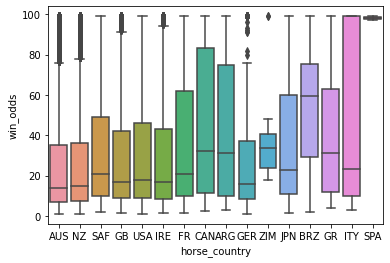

In [6]:
sns.boxplot(x="horse_country",y="win_odds",data=runs_df)
plt.show()

#### Win Odds and Horse Type

Next, we looked at horse type, which based on previous labs tended to be an important feature. Geldings, Browns, and Greys had smaller distributions of win odds. Geldings had the best odds on average. Ris, Colts, and Fillys would be less sure bets based on the distribution of odds for those types of horses.

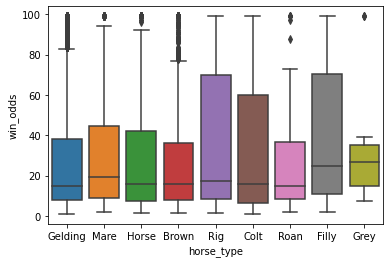

In [7]:
sns.boxplot(x="horse_type",y="win_odds",data=runs_df)
plt.show()

#### Win Odds and Finish Place

Based on previous labs, far and away the most important feature in determining a result was the horse's win odds. The graph below plots that relationship. As can be seen, there is a strong relationship. Horses with better odds were not only more likely to win (based on mean) but had much smaller distributions. Intuitively, this makes sense. Horse odds are set by professionals who have the best information and insight into the chances a horse will win a particular race.

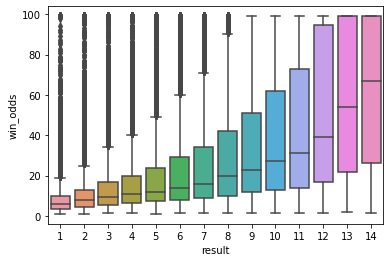

In [8]:
sns.boxplot(x='result', y='win_odds', data=runs_df)
plt.show()

#### Place Odds and Finish Position

Similarly to win odds, we plotted place odds against result. As would be expected, the relationship is very similar to win odds. In fact the range of distribution is smaller. That makes sense since win is determined by a horse finishing in a single position (1) whereas place is the horse finishing in first through third, so it is more forgiving. 

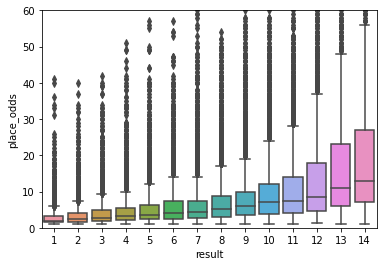

In [9]:
sns.boxplot(x='result', y='place_odds', data=runs_df)
plt.ylim(0,60)
plt.show()

#### Draw and Finish Position

The draw of a horse is random. Which horse begins the race in which stall is not determined by win odds or any other factor. It's a well known fact in racing that the "inside" track is preferred since it reduces the overall distance you have to travel. Therefore it intuitively makes sense that a horse beginning the race inside (draw 1) would have a slightly better chance in the race.

The chart below backs this up, to an extent. It is clear that the higher draw a hhorse has (the further from pole position they begin), the worse result they have on average.

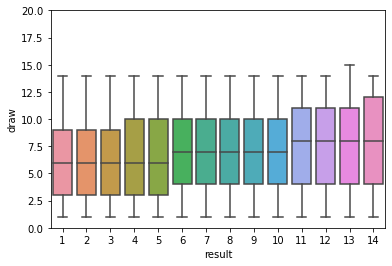

In [10]:
sns.boxplot(x='result', y='draw', data=runs_df)
plt.ylim(0,20)
plt.show()

#### Win Odds vs Result with Confidence Interval

Since it is clear there is a strong relationship between a horse's win or place odds and their result, we took another look at that relationship in another way.

The two plots below show the linear relationship between win odds an result, and place odds and result, with confidence intervals. Note how small he intervals. As the odds for a horse get worse, the interval gets larger, but only slightly. 

<AxesSubplot:xlabel='result', ylabel='win_odds'>

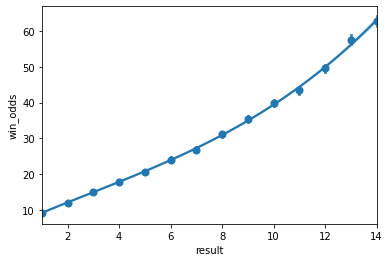

In [11]:
sns.regplot(x="result", y="win_odds", data=runs_df, x_estimator=np.mean, order=3)

#### Place Odds vs Result with Confidence Interval

Refer to the description above.

<AxesSubplot:xlabel='result', ylabel='place_odds'>

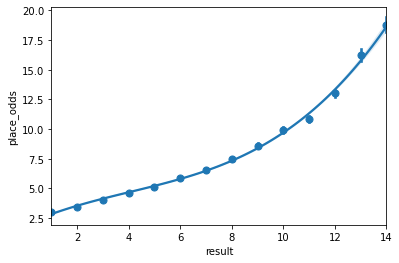

In [12]:
sns.regplot(x="result", y="place_odds", data=runs_df, x_estimator=np.mean, order=3)

#### Draw vs Result with Confidence Interval

Again, we plotted the linear relationship. This time between draw and result. We showed earlier their is a relationship between draw and result, but you could see it was not as strong as the relationship between win or place odds and result.

The confidence intervals for the below plot support the claim that the relationship is not as strong. The confidence intervals are not nearly as tight, meaning their is a wider distribution. So, the draw is an important feature in result, but it is not as much of a "sure thing" as win or place odds.

<AxesSubplot:xlabel='result', ylabel='draw'>

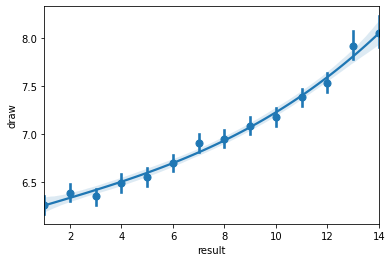

In [13]:
sns.regplot(x="result", y="draw", data=runs_df, x_estimator=np.mean, order=3)

#### Win Odds vs Place Odds, by Result

The last plot we chose to include in this report is a scatterplot showing win odds vs. place odds, categorized by result. The lighter the color, the better result, or finishing position. The darker the color, the worse the result.

It is clear, on the bottom-left of the graph the data points are lighter. In other words, a horse with lower win and place odds tends to finish the race in a better position. 

For this we filtered the data set for place odds of less than 30:1. There are a large number of outliers that make the plot less clear to read. We included the unfiltered plot below, for reference.

<AxesSubplot:xlabel='win_odds', ylabel='place_odds'>

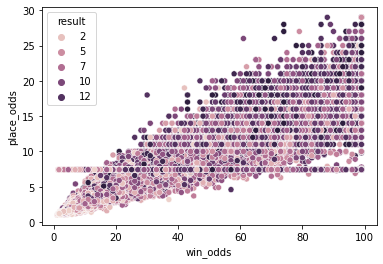

In [14]:
runs_df_lower_odds = runs_df[runs_df['place_odds'] < 30] 
sns.scatterplot(x='win_odds', y='place_odds', hue='result', data=runs_df_lower_odds)

#### Same plot but unfiltered for outliers

<AxesSubplot:xlabel='win_odds', ylabel='place_odds'>

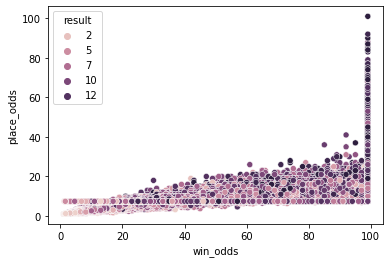

In [15]:
sns.scatterplot(x='win_odds', y='place_odds', hue='result', data=runs_df)

## Section 4: Modeling and Evaluation 1

### Section 4.1 K-Means Clustering

For the first K-means model, we used all parameters from the train data set. We put the model in a for-loop and incremented the number of clusters from 2 to 20. For each iteration we recorded the AUC and precision of the model to compare. 

Since we elected to use AUC as our primary metric, the model with the highest AUC is selected as the best number of clusters.

#### Test/Train Split and Scale

In [16]:
X_train,X_test,Y_train,Y_test = train_test_split(runs_data,runs_target,test_size=0.20,random_state=0)
mmscl_obj = MinMaxScaler()
X_train = mmscl_obj.fit_transform(X_train,y = None)
X_test = mmscl_obj.transform(X_test)

#### 4.1.1 KMeans Full - all features

In [17]:
best_auc_cluster = 0
best_auc = 0

for x in range(2,20):
    
    kmeans = KMeans(
        init='k-means++',  # initialization
        n_clusters=x,      # number of clusters
        n_init=10,         # number of different times to run k-means
        algorithm='full')
        
    kmeans.fit(X_train)

    yhat= kmeans.predict(X_test)
    prec = mt.precision_score(Y_test,yhat,average='micro')
    auc = roc_auc_score(Y_test,yhat)
    if (auc > best_auc):
        best_auc = auc
        best_auc_cluster = x
        print('Found a better k: Precision is: %.3f'%(prec), ' AUC: %.3f'%auc, ' for clusters=',x)

print('Best AUC: %.3f'%(best_auc), ' for clusters=',best_auc_cluster)

Found a better k: Precision is: 0.396  AUC: 0.494  for clusters= 2
Found a better k: Precision is: 0.285  AUC: 0.511  for clusters= 3
Found a better k: Precision is: 0.199  AUC: 0.540  for clusters= 6
Found a better k: Precision is: 0.058  AUC: 0.556  for clusters= 10
Best AUC: 0.556  for clusters= 10


#### 4.1.2 KMeans Elkan - all features

Next, we re-ran the same model as above but changed the sklearn KMeans algorithm parameter from the default (full) to "elkan". According to the sklearn documentation, elkan is best suited for data with well defined clusters. For this model, we did not believe that to be the case but ran the model anyway. The model not only took longer to train but it did not typically achieve as high of an AUC score as the previous "full" model. Although there was some variability in results from run to run, even with n_init set to 10.

Source: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html?highlight=kmeans#sklearn.cluster.KMeans

In [18]:
best_auc_cluster = 0
best_auc = 0

for x in range(2,20):
    
    kmeans = KMeans(
        init='k-means++',  # initialization
        n_clusters=x,      # number of clusters
        n_init=10,         # number of different times to run k-means
        algorithm='elkan')

    kmeans.fit(X_train)

    yhat= kmeans.predict(X_test)
    prec = mt.precision_score(Y_test,yhat,average='micro')
    auc = roc_auc_score(Y_test,yhat)
    if (auc > best_auc):
        best_auc = auc
        best_auc_cluster = x
        print('Found a better k: Precision is: %.3f'%(prec), ' AUC: %.3f'%auc, ' for clusters=',x)
    
print('Best AUC: %.3f'%(best_auc), ' for clusters=',best_auc_cluster)

Found a better k: Precision is: 0.604  AUC: 0.506  for clusters= 2
Found a better k: Precision is: 0.175  AUC: 0.508  for clusters= 7
Found a better k: Precision is: 0.081  AUC: 0.540  for clusters= 8
Best AUC: 0.540  for clusters= 8


#### 4.1.3 KMeans and KMeans Mini Batch - Win and Place Odds

From the data exploration we performed in Section 3 of this report as well as previous reports, we know the most important features in the data set for predicting winners and losers to be Win Odds and Place Odds.

For this K-means model, we ran with only those predictors included in the training data to visualize the clustering and compare the performance to the previous models.

In [19]:
win_place_train=X_train[:,[6,7]] # Create an array with win odds, place odds
win_place_test=X_test[:,[6,7]]

In [20]:
best_auc_cluster = 0
best_auc = 0
auc_plot_KMeans = []
auc_plot_KMeansMini = []

for x in range(2,20):

    kmeans_mini = MiniBatchKMeans(n_clusters=x, batch_size=10,random_state=0)
    kmeans = KMeans(n_clusters=x,random_state=0)

    kmeans.fit(win_place_train)
    kmeans_mini.fit(win_place_train)

    yhat= kmeans.predict(win_place_test)
    prec = mt.precision_score(Y_test,yhat,average='micro')
    auc = roc_auc_score(Y_test,yhat)
    if (auc > best_auc):
        best_auc = auc
        best_auc_cluster = x
        print('Found a better k: KMeans Precision is: %.3f'%(prec), ' AUC: %.3f'%auc, ' for clusters=',x)
    auc_plot_KMeans.append(auc)
    
    yhat= kmeans_mini.predict(win_place_test)
    prec = mt.precision_score(Y_test,yhat,average='micro')
    auc = roc_auc_score(Y_test,yhat)
    if (auc > best_auc):
        best_auc = auc
        best_auc_cluster = x
        print('Found a better k: KMeans Mini Precision is: %.3f'%(prec), ' AUC: %.3f'%auc, ' for clusters=',x)
        print('')
    auc_plot_KMeansMini.append(auc)

print('Best AUC: %.3f'%(best_auc), ' for clusters=',best_auc_cluster)

Found a better k: KMeans Precision is: 0.727  AUC: 0.401  for clusters= 2
Found a better k: KMeans Precision is: 0.218  AUC: 0.491  for clusters= 3
Found a better k: KMeans Mini Precision is: 0.165  AUC: 0.713  for clusters= 4

Best AUC: 0.713  for clusters= 4


#### 4.1.3.1 KMeans and KMeans Mini Batch - Visualize Number of Cluster Performance

In the above models, the AUC scores were saved off so we could plot them.

The first plot is for the K-Means model and the second is for the K-Means Mini-Batch model, which performed better than the regular K-Means.

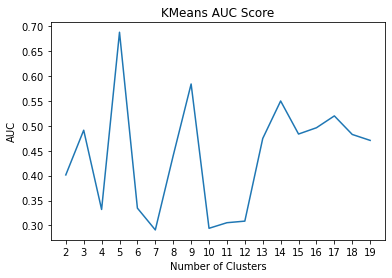

In [21]:
plt.plot(auc_plot_KMeans)
plt.title('KMeans AUC Score')
plt.xlabel('Number of Clusters')
plt.ylabel('AUC')
plt.xticks(np.arange(len(auc_plot_KMeans)), np.arange(2, len(auc_plot_KMeans)+2))

plt.show()

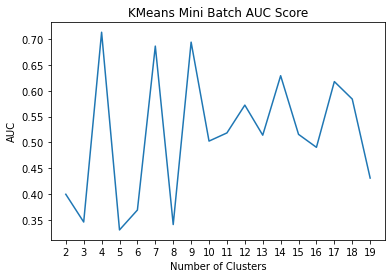

In [22]:
plt.plot(auc_plot_KMeansMini)
plt.title('KMeans Mini Batch AUC Score')
plt.xlabel('Number of Clusters')
plt.ylabel('AUC')
plt.xticks(np.arange(len(auc_plot_KMeansMini)), np.arange(2, len(auc_plot_KMeans)+2))

plt.show()

As can be seen above, in either K-Means or K-Means Mini-Batch there is no clear answer to how many clusters should be used. In both plots, a lower cluster value appears to perform better: they have higher AUC values.

#### 4.1.3.2 KMeans and KMeans Mini Batch - Silhouette Score

Due to the underwhelming visual above, we looked at another metric to attempt to judge the ideal number of clusters. We used Silhouette Score from the sklearn metric library. From the sklearn manual, "the Silhouette Coefficient is calculated using the mean intra-cluster distance and the mean nearest-cluster distance for each sample." It is a value between 1 and -1, with higher values indicating more well-defined clusters.

Source: https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient

In [23]:
# Note: this code block takes a while to execute so we only run for k = 2 to 10

sil = []
kmax = 10

for k in range(2, kmax+1):
  kmeans_sil = KMeans(n_clusters = k).fit(win_place_train)
  labels = kmeans_sil.labels_
  sil.append(silhouette_score(win_place_train, labels, metric = 'euclidean'))

# Source: https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb

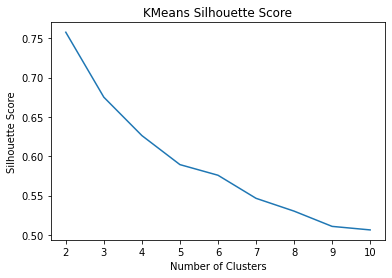

In [24]:
# Plot the above

plt.plot(sil)
plt.title('KMeans Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(np.arange(len(sil)), np.arange(2, len(sil)+2))

plt.show()

The Silhouette Score plot supports our claim that a lower number of clusters is better. There is a steep drop in performance as you increase the number of clusters.

#### 4.1.3.3 KMeans and KMeans Mini Batch - Plot the Clusters

After running the above models for all numbers of clusters from 2 to 20, we determined the number of clusters that produced the best AUC to be 4.

With that determination, we re-ran the K-Means model and plotted the results so we could visualize the clustering. If you recall the Win Odds vs Place Odds scatterplot from Section 3 Data Understanding, the below will look very familiar. Instead of coloring each point based on Result (place the horse finished) as we did in Section 3, here the data points are colored by the cluster they were assigned to.

We plot both the results from K-Means and K-Means Mini-Batch. Recall that K-Means Mini-Batch performed better in general.

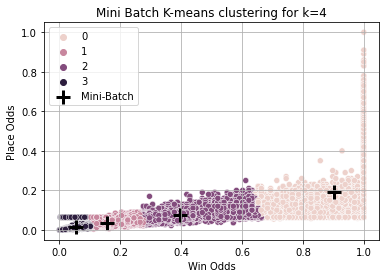

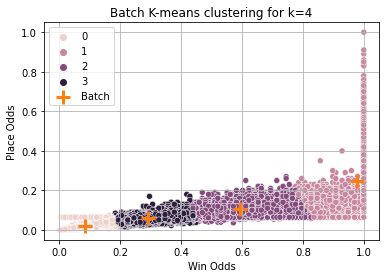

In [25]:
kmeans_mini = MiniBatchKMeans(n_clusters=best_auc_cluster, batch_size=10,random_state=0)
kmeans = KMeans(n_clusters=best_auc_cluster,random_state=0)

kmeans.fit(win_place_train)
kmeans_mini.fit(win_place_train)
    
c_mini=kmeans_mini.labels_
sns.scatterplot(win_place_train[:, 0], win_place_train[:, 1], hue=c_mini)
centroids = kmeans_mini.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='+', s=200, linewidths=3, color='k',label='Mini-Batch')
plt.legend()
plt.title('Mini Batch K-means clustering for k=4')
plt.xlabel('Win Odds')
plt.ylabel('Place Odds')
plt.grid()
plt.show()

c_means=kmeans.labels_
sns.scatterplot(win_place_train[:, 0], win_place_train[:, 1], hue=c_means)
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='+', s=200, linewidths=3, label='Batch')
plt.legend()
plt.title('Batch K-means clustering for k=4')
plt.xlabel('Win Odds')
plt.ylabel('Place Odds')
plt.grid()
plt.show()

#### 4.1.4 K-Means and K-Means Mini Batch - Win and Place Odds Filtered

As we discussed in Section 3, if we filter the Place Odds for only those with odds of less than 30:1, to data plots much cleaner. Next, we filtered the data similarly and created models with it to compare to the unfiltered model.

In terms of model deployment, this is not very useful. If you are gambling, the most money is to be made on higher longer odds bets. Additionally, we do not have a statistical reason to filter out these "outliers".

In [26]:
# Filter the place odds
runs_data_sub = runs_df_lower_odds.drop(['Unnamed: 0','race_id','horse_id','result','won','lengths_behind','horse_gear','position_sec1','position_sec2','position_sec3','behind_sec1','behind_sec2','behind_sec3','time1','time2','time3','finish_time','trainer_id','jockey_id','show','horse_no','horse_age','horse_country','horse_type','horse_rating','declared_weight','actual_weight'], axis=1)
runs_target_sub = runs_df_lower_odds['won']

X_train_sub,X_test_sub,Y_train_sub,Y_test_sub = train_test_split(runs_data_sub,runs_target_sub,test_size=0.20,random_state=0)

mmscl_obj = MinMaxScaler()
X_train_sub = mmscl_obj.fit_transform(X_train_sub,y = None)
X_test_sub = mmscl_obj.transform(X_test_sub)

win_place_train_odds_sub=X_train_sub[:,[1,2]] # Create an array with win odds, place odds
win_place_test_odds_sub=X_test_sub[:,[1,2]]

In [27]:
# Re-run the models
best_auc_cluster = 0
best_auc = 0

for x in range(2,20):
    
    kmeans_mini = MiniBatchKMeans(n_clusters=x, batch_size=10,random_state=0)
    kmeans = KMeans(n_clusters=x,random_state=0)

    kmeans.fit(win_place_train_odds_sub)
    kmeans_mini.fit(win_place_train_odds_sub)

    yhat= kmeans.predict(win_place_test_odds_sub)
    prec = mt.precision_score(Y_test_sub,yhat,average='micro')
    auc = roc_auc_score(Y_test_sub,yhat)
    if (auc > best_auc):
        best_auc = auc
        best_auc_cluster = x
        print('Found a better k: KMeans Precision is: %.3f'%(prec), ' AUC: %.3f'%auc, ' for clusters=',x)

    yhat= kmeans_mini.predict(win_place_test_odds_sub)
    prec = mt.precision_score(Y_test_sub,yhat,average='micro')
    auc = roc_auc_score(Y_test_sub,yhat)
    if (auc > best_auc):
        best_auc = auc
        best_auc_cluster = x
        print('Found a better k: KMeans Mini Precision is: %.3f'%(prec), ' AUC: %.3f'%auc, ' for clusters=',x)
        print('')

print('Best AUC: %.3f'%(best_auc), ' for clusters=',best_auc_cluster)

Found a better k: KMeans Precision is: 0.745  AUC: 0.414  for clusters= 2
Found a better k: KMeans Mini Precision is: 0.255  AUC: 0.586  for clusters= 2

Found a better k: KMeans Precision is: 0.102  AUC: 0.595  for clusters= 7
Found a better k: KMeans Mini Precision is: 0.043  AUC: 0.634  for clusters= 11

Found a better k: KMeans Precision is: 0.091  AUC: 0.672  for clusters= 16
Best AUC: 0.672  for clusters= 16


Surprisingly, this model performed worse than the unfiltered model. This is most likely because observations with Place Odds of greater than 30:1 make up a large part of the data set, therefore we had less to train on. However, one would have thought removing more "extreme" points would have made up for that.

Since the model performed Comparatively poor and is not useful in model deployment, we do not show the plots here.

#### 4.1.5 KMeans and KMeans Mini Batch - Win Odds, Place Odds, and Draw

For the next KMeans model, we added the Draw feature into the predictors. Our data exploration in this lab and previous labs showed the three most significant features for predicting wins and losses are: win odds, place odds, and draw.

We start by creating another Silhouette Score plot.

In [28]:
draw_win_place_train=X_train[:,[5,6,7]] # Create an array with win odds, place odds, draw

sil = []
kmax = 10

for k in range(2, kmax+1):
  kmeans_sil = KMeans(n_clusters = k).fit(draw_win_place_train)
  labels = kmeans_sil.labels_
  sil.append(silhouette_score(win_place_train, labels, metric = 'euclidean'))

# Source: https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb

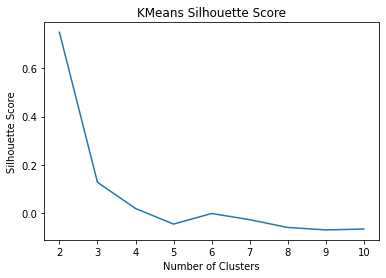

In [29]:
plt.plot(sil)
plt.title('KMeans Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(np.arange(len(sil)), np.arange(2, len(sil)+2))

plt.show()

The Silhouette Score plot above suggests the number of clusters for this model (win odds, place odds, and draw) will be similar to the previous models (win odds and place odds), but with a quicker drop off in performance when increasing the number of clusters.

We run K-Means and K-Means Mini-Batch for all numbers of clusters from 2 to 20 and compare the AUC.

In [30]:
draw_win_place_test=X_test[:,[5,6,7]] # Create an array with win odds, place odds, draw

best_auc_cluster = 0
best_auc = 0
auc_plot_KMeans = []
auc_plot_KMeansMini = []

for x in range(2,20):

    kmeans_mini = MiniBatchKMeans(n_clusters=x, batch_size=10,random_state=0)
    kmeans = KMeans(n_clusters=x,random_state=0)

    kmeans.fit(draw_win_place_train)
    kmeans_mini.fit(draw_win_place_train)

    yhat= kmeans.predict(draw_win_place_test)
    prec = mt.precision_score(Y_test,yhat,average='micro')
    auc = roc_auc_score(Y_test,yhat)
    if (auc > best_auc):
        best_auc = auc
        best_auc_cluster = x
        print('Found a better k: KMeans Precision is: %.3f'%(prec), ' AUC: %.3f'%auc, ' for clusters=',x)
    auc_plot_KMeans.append(auc)
    
    yhat= kmeans_mini.predict(draw_win_place_test)
    prec = mt.precision_score(Y_test,yhat,average='micro')
    auc = roc_auc_score(Y_test,yhat)
    if (auc > best_auc):
        best_auc = auc
        best_auc_cluster = x
        print('Found a better k: KMeans Mini Precision is: %.3f'%(prec), ' AUC: %.3f'%auc, ' for clusters=',x)
        print('')
    auc_plot_KMeansMini.append(auc)

print('Best AUC: %.3f'%(best_auc), ' for clusters=',best_auc_cluster)

Found a better k: KMeans Precision is: 0.278  AUC: 0.600  for clusters= 2
Best AUC: 0.600  for clusters= 2


As the Silhouette Score indicated, lower numbers of clusters give better AUC scores with two clusters providing the best score. This confirms our intuition from the the Silhouette Score plot.

We make a final K-Means model using this number of clusters and plot the results in three dimensions.

#### 4.1.5.1 KMeans Mini Batch - Win Odds, Place Odds, and Draw

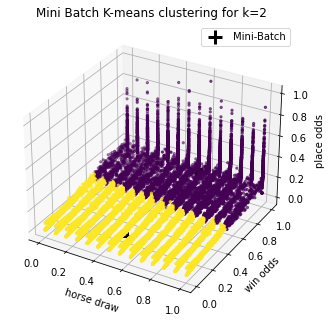

In [32]:
# visualize the model with best number of clusters
kmeans_mini = MiniBatchKMeans(n_clusters=best_auc_cluster, batch_size=10,random_state=0)
kmeans_mini.fit(draw_win_place_train)

fig = plt.figure()
ax = Axes3D(fig)

c_mini=kmeans_mini.labels_
ax.scatter(draw_win_place_train[:,0], draw_win_place_train[:,1], draw_win_place_train[:,2],c=c_mini,s=5)
centroids = kmeans_mini.cluster_centers_
ax.scatter(centroids[:, 0], centroids[:, 1],centroids[:, 2],
            marker='+', s=200, linewidths=3, color='k',label='Mini-Batch',depthshade=False)  # plot the centroids
ax.legend()
plt.title('Mini Batch K-means clustering for k=2')
plt.xlabel('horse draw')
plt.ylabel('win odds')
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('place odds', rotation=90)
plt.show()

#### 4.1.4 K-Means Summary

For Section 4.1 we generated several K-Means models.

First, we used all predictors. Second, we used the place and win odds predictors. We made a variation of this model where we filtered out more "extreme" place odds although it does not provide much practical benefit. Lastly, we used place odds, win odds, and draw. Our data exploration in Section 3 led us to select these predictors to focus on.

For the models, we varied several parameters. We tried "full" and "Elkan" versions of the model. Compared the performance for all numbers of clusters from 2 to 20. We used K-Means and K-Means Mini-Batch.

The model with the best AUC was the K-Means Mini-Bath with k=4 and place odds and win odds for predictors (Section 4.1.3.3). We achieved an AUC of 0.713. The K-Means Mini-Bath with k=4 for place odds, win odds, and the addition of draw, was only able to achieve an AUC of 0.600 (Section 4.1.5.1).

## Section 5: Modeling and Evaluation 2

Evaluate and Compare

...

## Section 6: Modeling and Evaluation 3

Visualize Results

...

## Section 7: Modeling and Evaluation 4

Summarize the Ramifications

...

## Section 8: Deployment

Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling? How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?

...

## Section 9: Exceptional Work

You have free reign to provide additional analyses or combine analyses.

...